**CURSO**: *Machine Learning* en Geociencias<br />
**Profesor**: Edier Aristizábal (evaristizabalg@unal.edu.co) <br />
**Credits**: The content of this notebook is taken from several sources: Marco Peixeiro, Soner Yıldırım, Bex T, Manuel Hupperich, Destin Gong, Youssef Hosni and Piero Paialunga en www.towardsdatascience.com. Every effort has been made to trace copyright holders of the materials used in this book. The author apologies for any unintentional omissions and would be pleased to add an acknowledgment in future editions.

# Time Series Analysis: SARIMAX


In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 20.6 MB/s 
     |████████████████████████████████| 9.9 MB 59.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [3]:
import statsmodels.api as sm
from typing import Union
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from itertools import product

import warnings
warnings.filterwarnings('ignore')

## Random Walk Model

A random walk is a process in which there is an equal chance of going up or down by a random number.

$X_t=X_{t -1} + \epsilon_t$

The location at the present time *t* is the sum of the previous location and noise, expressed by $\epsilon$. Here, we assume that the noise is normally distributed (mean of 0 and variance of 1)

In [6]:
steps = np.random.standard_normal(1000)
steps[0]=0
random_walk = np.cumsum(steps)

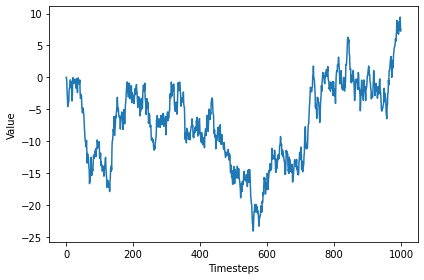

In [7]:
fig, ax = plt.subplots()
ax.plot(random_walk)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
plt.tight_layout()

[1.         0.98431888 0.97002793 0.95524022 0.94236577 0.92913793
 0.9168812  0.90405419 0.89215754 0.87944516 0.86790795 0.85659705
 0.84570612 0.83489508 0.8229835  0.81145811 0.79938921 0.78628656
 0.77364664 0.76163329 0.75033605 0.7394467  0.7302206  0.72257999
 0.71551642 0.70717315 0.69962654 0.69199163 0.68512428 0.67722441
 0.66689452]


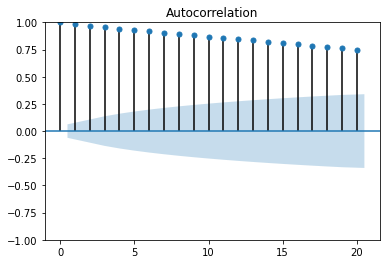

In [8]:
print(acf(random_walk))
plot_acf(random_walk, lags=20);

In the context of time series, a random walk is defined as a series whose first difference
is stationary and uncorrelated

The correlation is very important. Therefore, the process is not stationary. Knowing that a random walk adds a random noise to the previous point, if we take the difference between each point with its previous one, we should obtain a purely random stochastic process.

In [9]:
random_walk_diff = np.diff(random_walk, n=1)

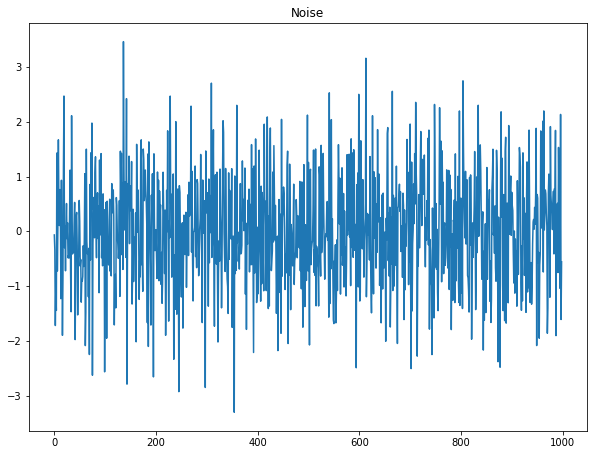

In [10]:
plt.figure(figsize=[10, 7.5]); # Set dimensions for figure
plt.plot(random_walk_diff)
plt.title('Noise')
plt.show()

The plot above has no systematic change in trend, variance, and it has no seasonality. Therefore, we definitely have a purely random process.

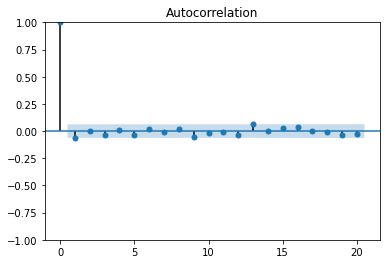

In [11]:
plot_acf(random_walk_diff, lags=20);

We see that this is the correlogram of a purely random process, where the autocorrelation coefficients drop at lag 1.

We defined a random walk process as a series whose first difference is stationary with no
autocorrelation. This means that plotting its ACF will show no significant coefficients after lag 0. However, it is possible that a stationary process still exhibits autocorrelation. In this case,
we have a time series that can be approximated by a moving average model MA(q), an
autoregressive model AR(p), or an autoregressive moving average model ARMA(p,q). We will first focus on identifying and modeling using the moving average model.

## Moving Average (MA) Process

Moving average model, MA(q) adjusts the model based on the average predictions errors from previous *q* observations. Again, the error terms are assumed
to be mutually independent and normally distributed, just like white noise.

A moving average model is denoted as MA(q) where q is the order. The model expresses
the present value as a linear combination of the mean of the series μ, the present error term
$ϵ_t$, and past error terms $ϵ_{t−q}$. The magnitude of the impact of past errors on the present value
is quantified using a coefficient denoted as $θ_q$. Mathematically, we express a general moving
average process of order q

$X_t=μ + \epsilon_y+\theta_1 \epsilon_{t-1}+\theta_2 \epsilon_{t-2}$

The equation above says that the position X at time t depends on the noise at time t, plus the noise at time t-1 (with a certain weight theta), plus some noise at time t-2 (with a certain weight). This is called a moving average process of order 2, which can also be denoted as MA(2). The generalized notation is MA(q). In the example above, q = 2.

### Ejemplo

$X_t=\epsilon_y+0.9 \epsilon_{t-1}+0.3 \epsilon_{t-2}$

In [12]:
ar2 = np.array([2])
ma2 = np.array([1, 0.9, 0.3])

In [13]:
MA2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

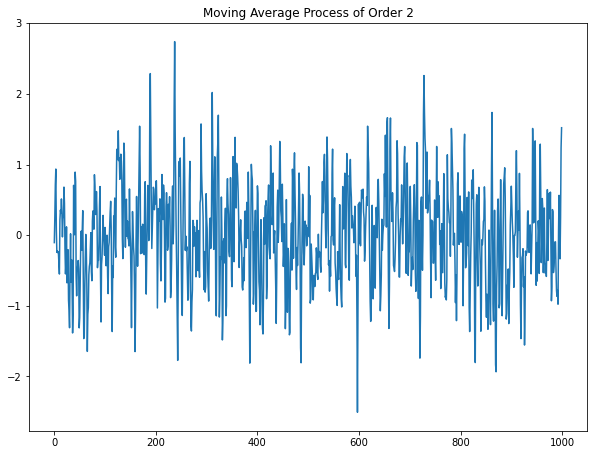

In [14]:
plt.figure(figsize=[10, 7.5]); # Set dimensions for figure
plt.plot(MA2_process)
plt.title('Moving Average Process of Order 2')
plt.show()

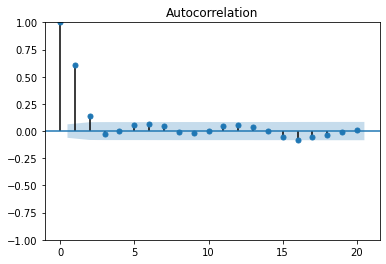

In [15]:
plot_acf(MA2_process, lags=20);

As you notice, the correlation is significant up to lag 2. Afterwards, the correlation is not significant anymore. This makes sense since we specified a formula with a lag of 2. This means that you can infer the lag of a time series using the correlogram. If you see that after a specific lag q, the correlation is not significant, then you can model your time series as an MA(q) process.

## Autoregressive (AR) Models

In the moving average process, we learned that in a moving average process, the present value is
linearly dependent on current and past error terms. Therefore, if we predict more than q
steps ahead, the prediction will fall flat and will return only the mean of the series because
the error terms are not observed in the data and must be recursively estimated. Finally, we
saw that we can determine the order of a stationary MA(q) process by studying the ACF plot;
the autocorrelation coefficients will be significant up until lag q. 

In the case where the
autocorrelation coefficients slowly decay or exhibit a sinusoidal pattern, then we are possibly
in the presence of an autoregressive process. Just like the MA(q) model, the AR(p) model will require us to identify its order. This time we will have to plot the partial autocorrelation function and see at which lag
coefficients suddenly become non-significant.

An autoregressive (AR) model uses a linear combination of past values of the target to make forecasts. Of course, the regression is made against the target itself. Mathematically, an AR(p) model is expressed as:

$X_t=μ+\phi_1 X_{t-1} +\phi_2 X_{t-2}+...++\phi_p X_{t-p} + \epsilon_t$

In the AR model, today's value is equal to the fraction ($\phi$) of yesterday's value in addition to noise and the mean,

### Ejemplo

$Y_t=1+0.33 y_{t-1} +0.5 y_{t-2}$

Since we are dealing with an autoregressive model of order 2, we need to define the coefficient at lag 0, 1 and 2. The first coefficient is always 1.

In [16]:
ar2 = np.array([1, 0.33, 0.5])
ma = np.array([1])
simulated_AR2_data = ArmaProcess(ar2, ma).generate_sample(nsample=10000)

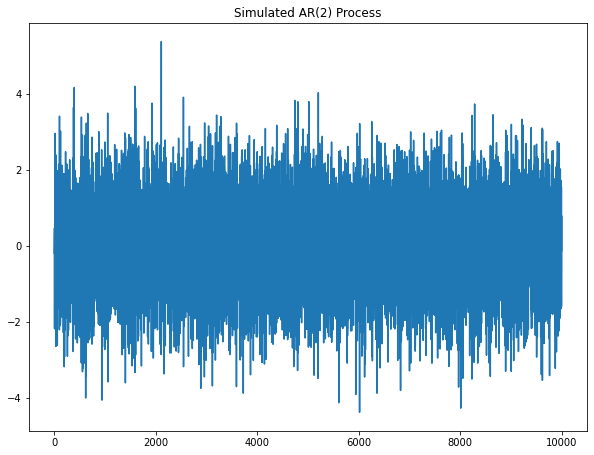

In [17]:
plt.figure(figsize=[10, 7.5]); # Set dimensions for figure
plt.plot(simulated_AR2_data)
plt.title("Simulated AR(2) Process")
plt.show()

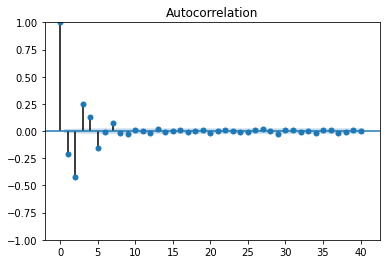

In [18]:
plot_acf(simulated_AR2_data);

You can see that the coefficient is slowly decaying. This means that it is unlikely a moving average process and it suggests that the time series can probably be modelled with an autoregressive process (which makes sense since that what we are simulating).

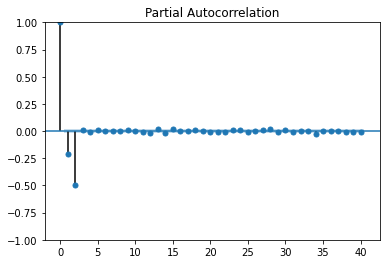

In [19]:
plot_pacf(simulated_AR2_data);

As you can see the coefficients are not significant after lag 2. Therefore, the partial autocorrelation plot is useful to determine the order of an AR(p) process.

You can also check the values of each coefficients by running:

In [ ]:
from statsmodels.tsa.stattools import pacf
pacf_coef_AR2 = pacf(simulated_AR2_data)
print(pacf_coef_AR2)

[ 1.00000000e+00 -2.22059081e-01 -5.03663160e-01  1.88030170e-03
  3.36948770e-03  1.30032052e-03  7.76263261e-03  3.57909418e-03
  3.70952575e-03  2.47829482e-03  1.14117404e-03  2.20468858e-03
 -1.26362115e-02  9.12976459e-03  3.79507313e-03 -6.42256510e-03
  4.33819379e-03 -7.50166500e-03 -7.92385155e-03 -6.62612486e-04
  1.63013273e-03 -5.37454109e-04  1.06765495e-03  8.24953120e-03
  7.03765584e-03 -8.47425800e-03 -1.20902488e-02 -2.36820253e-02
 -2.88485170e-03 -1.54833346e-02  3.58243705e-03  1.18078436e-02
 -8.37657835e-03 -1.29325575e-04 -2.31582592e-02 -3.00728614e-04
  1.98446974e-02  3.64807222e-03 -1.93804076e-03 -9.68397436e-03
  1.21395025e-03]


Now, in a real project setting, it can be easy to find the order of an AR(p) process, but we need to find a way to estimate the coefficients phi.

To do so, we use the Yule-Walker equation. This equations allows us to estimate the coefficients of an AR(p) model, given that we know the order.

In [ ]:
from statsmodels.regression.linear_model import yule_walker
rho, sigma = yule_walker(simulated_AR2_data, 2, method='mle')
print(f'rho: {-rho}')
print(f'sigma: {sigma}')

rho: [0.33384514 0.5035572 ]
sigma: 1.0029132795828726


As you can see, the Yule-Walker equation did a decent job at estimating our coefficients and got very close to 0.33 and 0.5.

## ARMA Model

We will examine the autoregressive moving average process or
ARMA(p,q), where p denotes the order of the autoregressive portion, and q denotes the order
of the moving average portion. Furthermore, we will not be able to use the ACF and PACF
plots to determine the orders q and p respectively, as both plots will show either a slowly decaying or sinusoidal pattern. If that is the case, we can move on to forecasting our time series using the ARMA(p,q) model.

Then, an ARMA(p,q) is simply the combination of both models into a single equation:

$Y_t=μ+ \epsilon_y+\theta_1 \epsilon_{t-1}+\theta_2 \epsilon_{t-2} +...+\theta_q \epsilon_{t-q} + C +\phi_1 y_{t-1} +\phi_2 y_{t-2}+...++\phi_p y_{t-p}$

Thus, if we have an ARMA(1,1) process, this means that we are combining an
autoregressive process of order 1, or AR(1), with a moving a moving average process of
order 1, or MA(1).



### Ejemplo

ARMA[1,1]

$Y_t=0.9 \epsilon_{t-1} + \epsilon_t+ 0.33 y_{t-1} $

The constant C and mean μ are both equal to 0. Also recall that when
defining your arrays of coefficients, the first coefficient is always equal to 1, as specified by
the library, which represents the coefficient at lag 0

In [20]:
ar1 = np.array([1, 0.33])
ma1 = np.array([1, 0.9])
simulated_ARMA_data = ArmaProcess(ar1, ma1).generate_sample(nsample=10000)

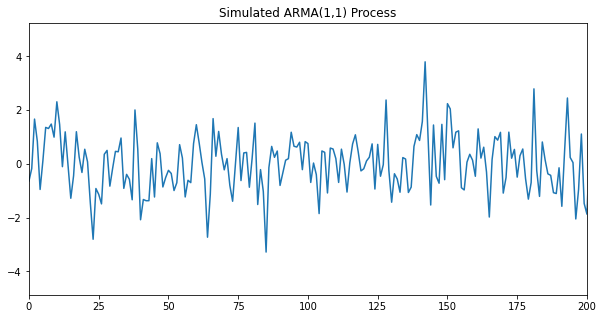

In [21]:
plt.figure(figsize=[10, 5]); 
plt.plot(simulated_ARMA_data)
plt.title("Simulated ARMA(1,1) Process")
plt.xlim([0, 200])
plt.show()

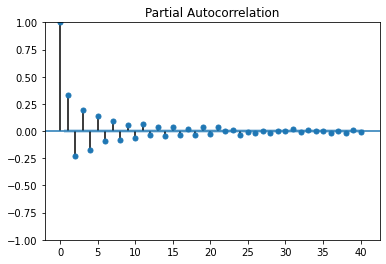

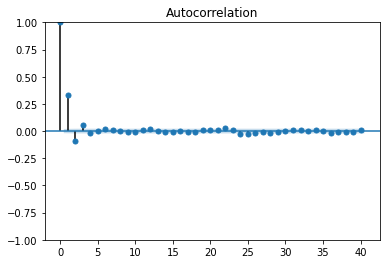

In [22]:
plot_pacf(simulated_ARMA_data);
plot_acf(simulated_ARMA_data);

As you can see, we cannot infer the order of the ARMA process by looking at these plots. In fact, looking closely, we can see some sinusoidal shape in both ACF and PACF functions. 

In [23]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(simulated_ARMA_data,order=(1,0,1))
history=model.fit()
history.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                10000
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -14113.179
Date:                Thu, 01 Dec 2022   AIC                          28234.358
Time:                        16:23:57   BIC                          28263.200
Sample:                             0   HQIC                         28244.121
                              - 10000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0154      0.014     -1.095      0.274      -0.043       0.012
ar.L1         -0.3429      0.012    -29.746      0.000      -0.366      -0.320
ma.L1          0.9047      0.005    172.363      0.000       0.894       0.915
sigma2         0.9848      0.014     71.265      0.000       0.958       1.012
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.82
Prob(Q):                              0.74   Prob(JB):                         0.66
Heteroskedasticity (H):               0.96   Skew:                            -0.02
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## ARIMA model



ARIMA stands for AutoRegressive Integrated Moving Average, which extends from ARMA model and incorporates the integrated component (inverse of differencing). In this context, integration is the opposite of differencing. Differencing is useful to remove the trend in a time series and make it stationary. It simply involves subtracting a point a t-1 from time t. Realize that you will, therefore, lose the first data point in a time series if you apply differencing once. Mathematically, the ARIMA(p,d,q) now requires three parameters:

* p: the order of the autoregressive process
* d: the degree of differencing (number of times it was differenced)
* q: the order of the moving average process

Just like with ARMA models, the ACF and PACF cannot be used to identify reliable values for p and q. Since ARIMA incorporates differencing in its model building process, it does not strictly require the training data to be stationary. To ensure that ARIMA model works well, the appropriate degree of differencing should be selected, so that time series is transformed to stationary data after being de-trended.

### Akaike’s Information Criterion (AIC)
This criterion is useful for selecting the order (p,d,q) of an ARIMA model. The AIC is expressed as:

$AIC=-2log(L)+2k$

Where L is the likelihood of the data and k is the number of parameters. In practice, we select the model with the lowest AIC compared to other models. It is important to note that the AIC cannot be used to select the order of differencing (d). Differencing the data will the change the likelihood (L) of the data. The AIC of models with different orders of differencing are therefore not comparable.

Also, notice that since we select the model with the lowest AIC, more parameters will increase the AIC score and thus penalize the model. While a model with more parameters could perform better, the AIC is used to find the model with the least number of parameters that will still give good results.

A final note on AIC is that it can only be used relative to other models. A small AIC value is not a guarantee that the model will have a good performance on unsee data, or that its SSE will be small.

In [24]:
data = pd.read_csv('https://raw.githubusercontent.com/youssefHosni/Time-Series-With-Python/main/Time%20Series%20Analysis/DJI.csv', parse_dates=['Date'], index_col='Date')
data.head()

,DJI,UFO
Date,,
1941-01-01,110.96,1
1942-01-01,119.40,2
1943-01-01,135.89,9
1944-01-01,152.32,9
1945-01-01,192.91,9


In [25]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [26]:
ps = range(0, 3, 1)
d = 1
qs = range(0, 3, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, exog=data['DJI'])
result_df

  0%|          | 0/9 [00:00<?, ?it/s]

,"(p, d, q)",AIC
0,"(1, 1, 2)",1179.964823
1,"(2, 1, 2)",1186.936985
2,"(0, 1, 0)",1192.366636
3,"(1, 1, 0)",1194.219564
4,"(0, 1, 1)",1194.305254
5,"(0, 1, 2)",1196.028696
6,"(2, 1, 0)",1196.107628
7,"(1, 1, 1)",1196.113958
8,"(2, 1, 1)",1197.917745


In [27]:
best_model = SARIMAX(data["DJI"], order=(1,1,2), simple_differencing=False).fit()
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                    DJI   No. Observations:                   73
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -585.982
Date:                Thu, 01 Dec 2022   AIC                           1179.965
Time:                        16:28:12   BIC                           1189.071
Sample:                    01-01-1941   HQIC                          1183.590
                         - 01-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9875      0.023    -42.497      0.000      -1.033      -0.942
ma.L1          1.8888      0.092     20.429      0.000       1.708       2.070
ma.L2          0.9971      0.101      9.896      0.0

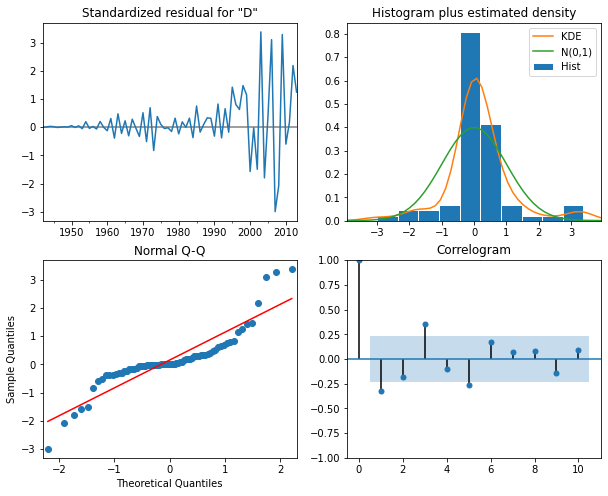

In [28]:
best_model.plot_diagnostics(figsize=(10,8));

We start our analysis by studying the top left plot. This displays the
standardized residuals over time. We see that there is no trend, and the variance looks
constant over time, which is a good point since this behavior is similar to that of white noise.
Then, the top right plot shows the distribution of the residuals. Ideally, it should approach a
normal distribution. We can see it is fairly close to a normal distribution, despite the unusual
peak. The Q-Q plot on the bottom left further supports that, since we see reasonably straight
line that lies on y = x. Finally, the bottom right plot shows the correlogram of the residuals.
We can see that there are not significant autocorrelation coefficients after lag 0, just like
white noise. Thus, from the qualitative analysis, the residuals are close to white noise,
meaning that the errors are random.

Our ARIMA(p,d,q) model has passed all checks and it can now be used for forecasting.

In [29]:
data["prediction"]=best_model.predict(start=58,end=64, dynamic=True)
data[["data","prediction"]].plot()

KeyError: ignored

## SARIMA Model


Up until now, we have not considered the effect of seasonality in time series. However, this behaviour is surely present in many cases, such as gift shop sales, or total number of air passengers. A seasonal ARIMA model or SARIMA is written as follows:

<img src="https://miro.medium.com/max/1400/1*yxe5Sf5JSAROq-UVgMLtmA.png">

The Seasonal Autoregressive Integrated Moving Average model, or SARIMA(p,d,q)(P,D,Q)m adds another set of parameters that allows us to take into account
periodic patterns when forecasting a time series which is not always possible with an
ARIMA(p,d,q) model.

The parameter m stands for the frequency, the number of observations in each period. In the context of time series, the frequency is
defined as the number of observations per cycle. Now, the length of the cycle will depend on the dataset. For data that was recorded every
year, quarter, month, or week, the length of a cycle is considered to be one year. In the case where the data is recorded annually, then m = 1, since there is only one observation per
year. If the data is recorded quarterly, then m = 4, since there are four quarters in a year,
therefore four observations per year. Of course, if the data is recorded monthly, then m = 12. Finally, for weekly data, m = 52.

When data is collected on a daily or sub-daily basis, then there are multiple ways of
interpreting the frequency. For example, daily data can have a weekly seasonality. In that
case, the frequency is m = 7 because there would be 7 observations in a full cycle of one
week. It could also have a yearly seasonality, meaning that m = 365. Thus, we can see how
daily and sub-daily data can have a different cycle length, and therefore a different
frequency m.

You can see that we add P, D, and Q for the seasonal portion of the time series. They are the same terms as the non-seasonal components, by they involve backshifts of the seasonal period. In the formula above, m is the number of observations per year or the period. If we are analyzing quarterly data, m would equal 4.

In [30]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp_results = seasonal_decompose(data['data'], period=1)
plt.rcParams["figure.figsize"] = (10,15)
decomp_results.plot()
plt.show()

KeyError: ignored

In [ ]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 1
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

result_df = optimize_SARIMA(parameters_list, 1, 1, 4, data['data'])
result_df

256


  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(2, 3, 0, 1)",-42.901218
1,"(2, 1, 0, 1)",-42.613183
2,"(2, 3, 1, 1)",-41.744704
3,"(0, 1, 1, 1)",-41.291747
4,"(0, 3, 0, 1)",-41.253797
...,...,...
251,"(1, 0, 0, 0)",5.724895
252,"(0, 0, 3, 0)",10.229596
253,"(0, 0, 2, 0)",14.080718
254,"(0, 0, 1, 0)",15.261236


In [ ]:
best_model = SARIMAX(data['data'], order=(2, 1, 3), seasonal_order=(0, 1, 1, 1)).fit(dis=-1)
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                data   No. Observations:                   72
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 4)   Log Likelihood                  28.451
Date:                             Thu, 15 Sep 2022   AIC                            -42.901
Time:                                     21:49:31   BIC                            -27.468
Sample:                                 01-01-1942   HQIC                           -36.794
                                      - 01-01-2013                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5135      0.060     -8.573      0.000      -0.631      -0.396
ar.L2         -0.9974      

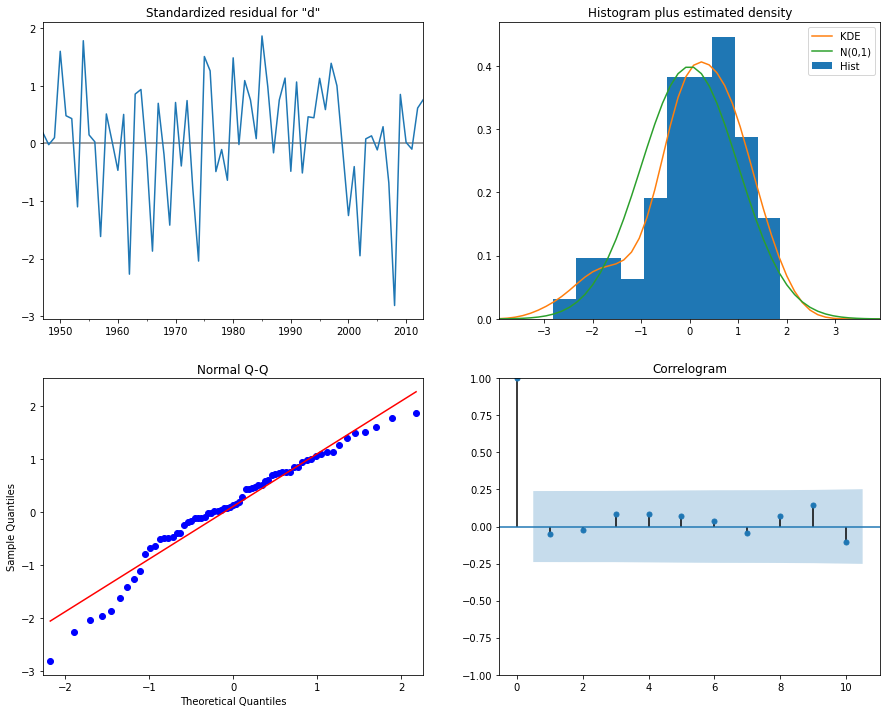

In [ ]:
best_model.plot_diagnostics(figsize=(15,12));

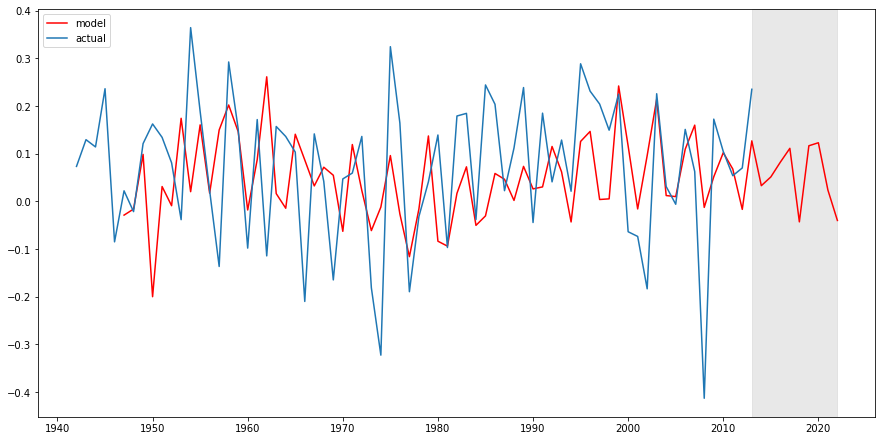

In [ ]:
data['arima_model'] = best_model.fittedvalues
data['arima_model'][:4+1] = np.NaN
forecast = best_model.predict(start=data.shape[0], end=data.shape[0] + 8)
forecast = data['arima_model'].append(forecast)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(data['data'], label='actual')
plt.legend()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1179.109, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1215.638, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1202.465, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1176.559, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1178.447, Time=0.07 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1178.400, Time=0.09 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1177.323, Time=0.17 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.708 seconds
 ARIMA(0,2,1)(0,0,0)[0]          
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   73
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -586.279
Date:                Thu, 01 Dec 2022   AIC                           1176.559
Time:  

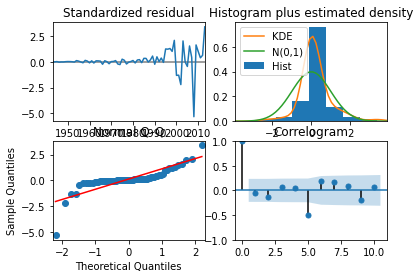

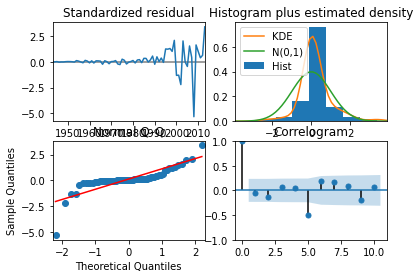

In [33]:
# Seasonal search parameters

results = auto_arima(data["DJI"], # data
                        seasonal=True, # is the time series seasonal
                        m=1, # the seasonal period
                        D=1, # seasonal difference order
                        start_P=1, # initial guess for P
                        start_Q=1, # initial guess for Q
                        max_P=4, # max value of P to test
                        max_Q=4, # max value of Q to test
                        information_criterion='aic', # used to select best model
                        trace=True, # print results whilst training
                        error_action='ignore', # ignore orders that don't work
                        stepwise=True,
                       )
print(results)
print(results.summary())
results.plot_diagnostics()

## Sarimax adding external variables

We started with only autoregressive and moving average processes, before combining them into the ARMA model.
Then, we added a layer of complexity that allows modeling non-stationary time series,
leading us to the ARIMA model. Finally, we added yet another layer to
ARIMA, which allows us to consider seasonal patterns in our forecasts, hence reaching the
SARIMA model.

Each model that we have explored and used to produce forecasts considers
only the time series itself. In other words, past values of the time series were used as
predictors for future values. However, it is possible that external variables also have an
impact on our time series and can therefore be good predictors of future values.

This brings us to the SARIMAX model. We notice the addition of the X term, which
denotes exogenous variables. Note that in statistics, the term exogenous is used to describe
predictors or input variables, while endogenous is used to define the target variable; what we
are trying to predict. Therefore, we can express the present value yt simply as a SARIMA(p,d,q)(P,D,Q)m
model to which we add any number of exogenous variables Xt:

$y_t=SARIMA(p,d,q)(P,D,Q)_m + \sum_{i=1}^n\beta_iX_t^i$

The SARIMAX model is the most general model for forecasting time series. We see that if we have no seasonal
patterns, then it becomes an ARIMAX model. With no exogenous variables, it is a SARIMA model. With no seasonality
or exogenous variables, it becomes an ARIMA model.

Let’s load the US macroeconomics dataset and explore the different exogenous variables
available to us to forecast the real GDP.

In [34]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


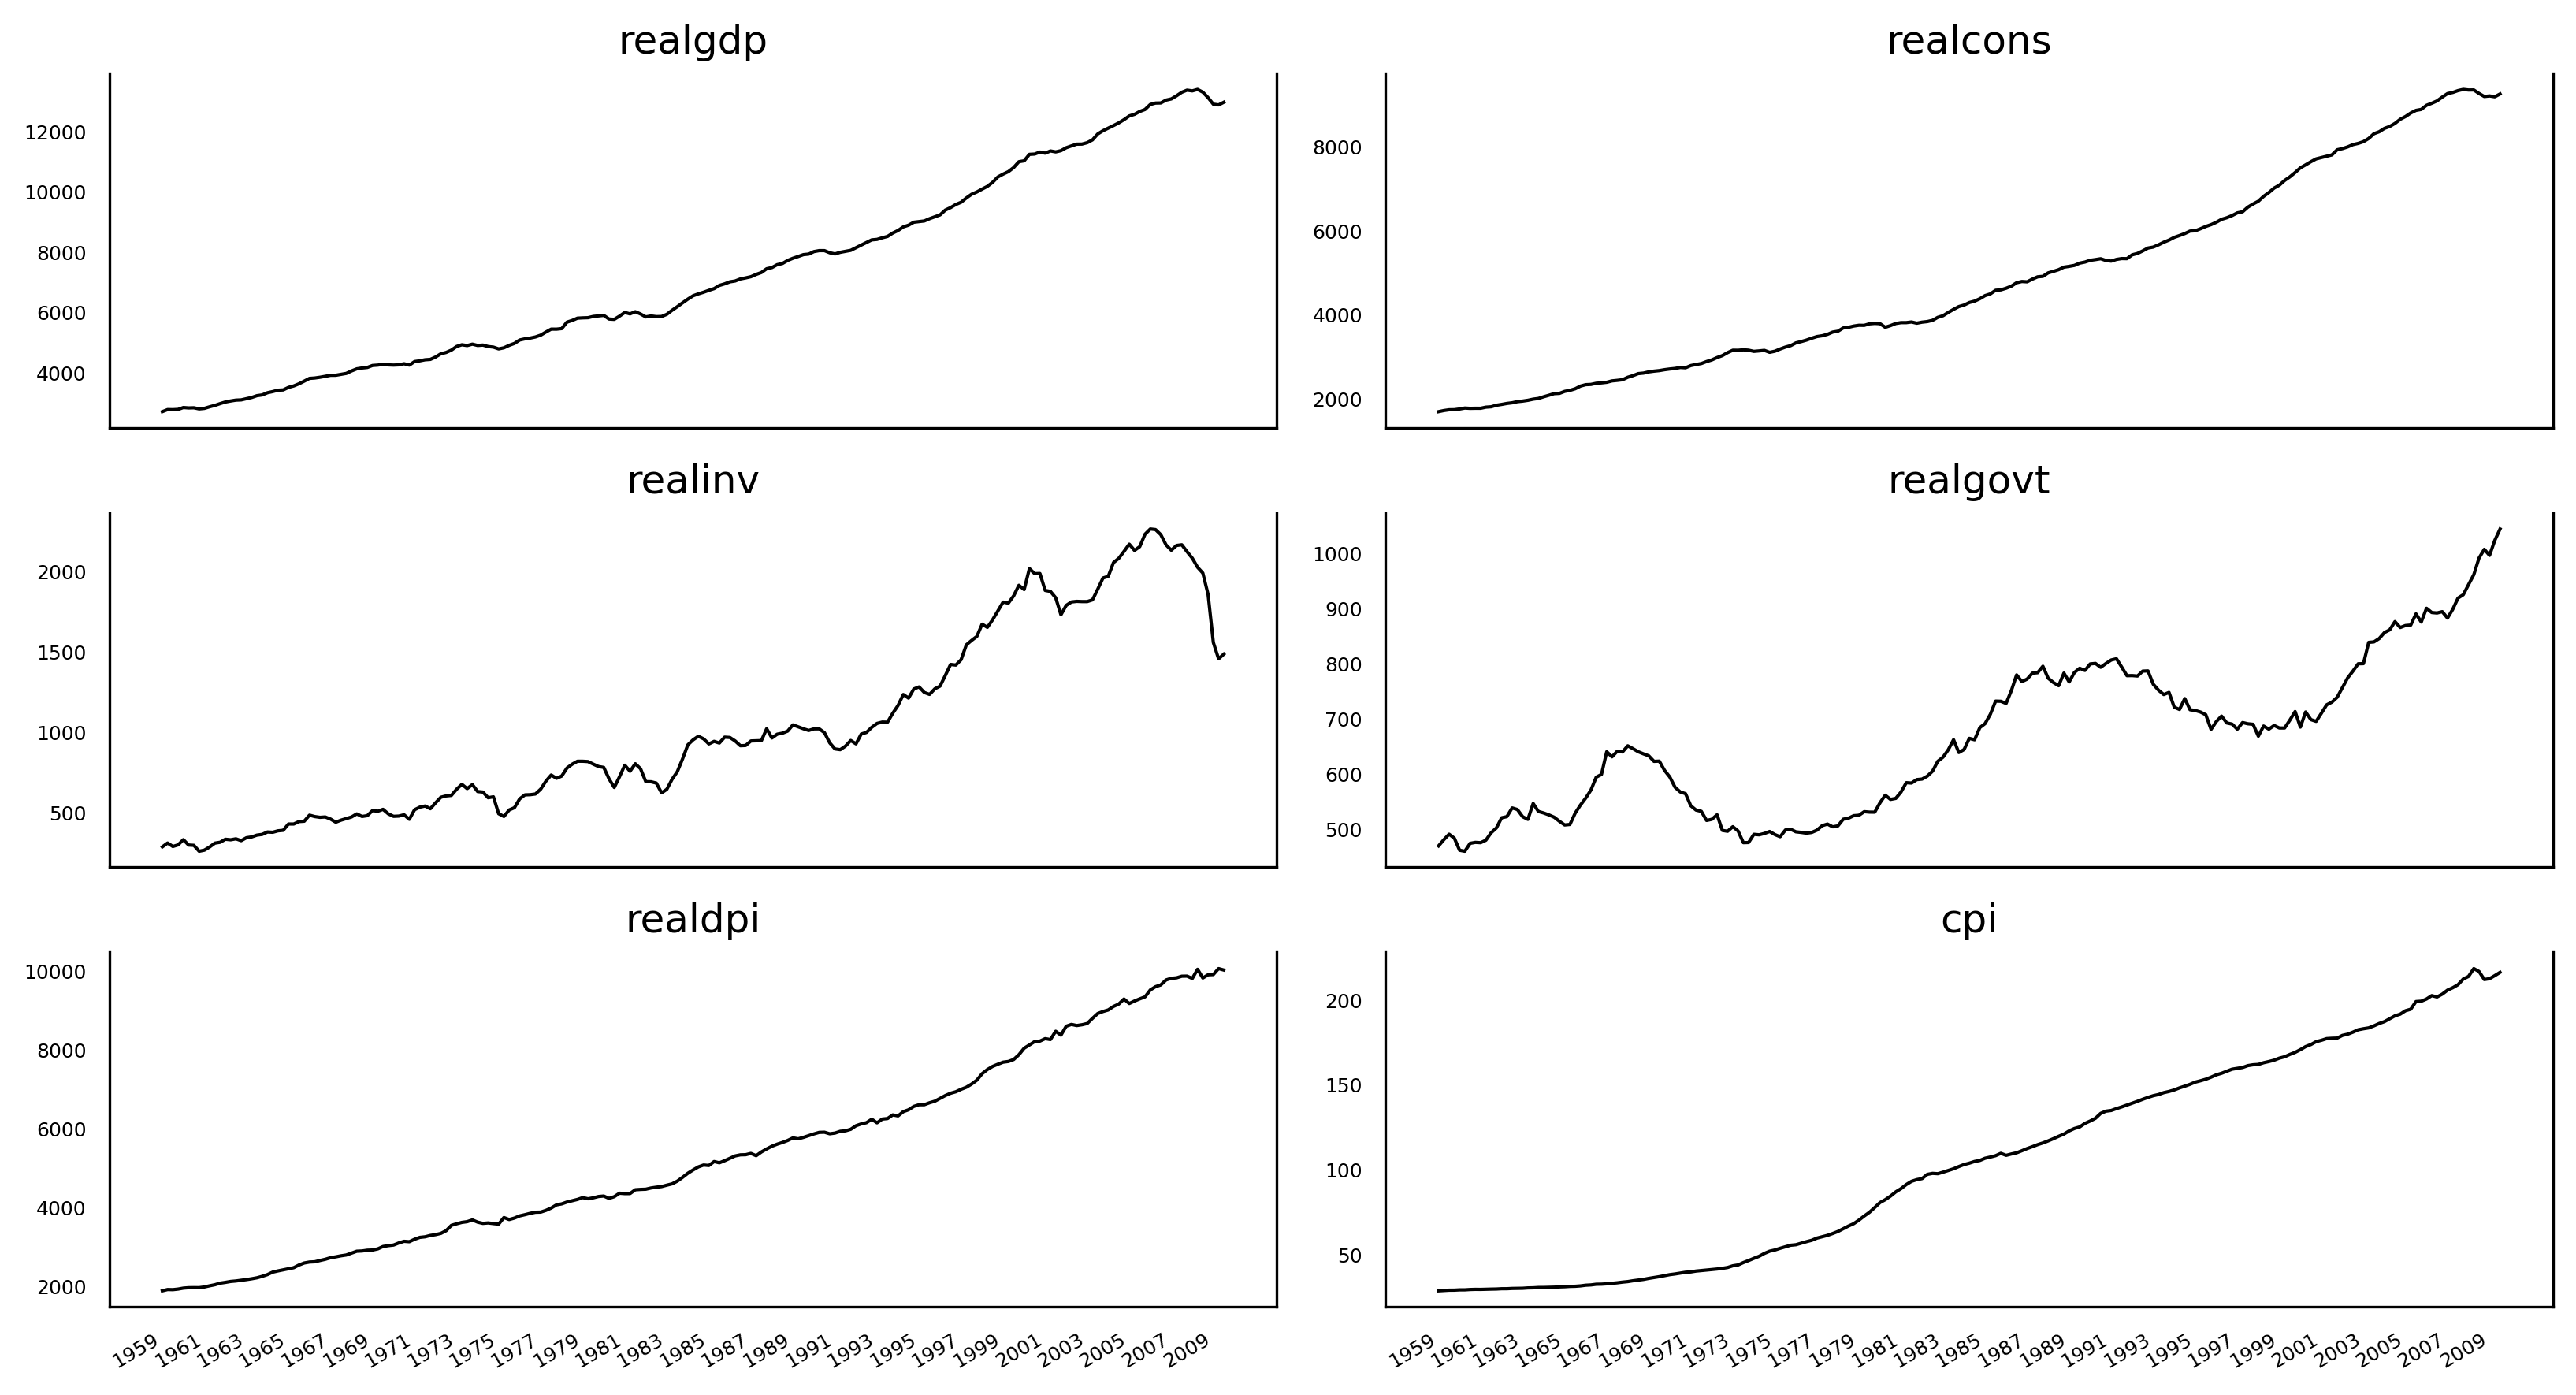

In [35]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=300, figsize=(11,6))
for i, ax in enumerate(axes.flatten()[:6]):
    data = macro_econ_data[macro_econ_data.columns[i+2]]
    ax.plot(data, color='black', linewidth=1)
    ax.set_title(macro_econ_data.columns[i+2])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.setp(axes, xticks=np.arange(0, 208, 8), xticklabels=np.arange(1959, 2010, 2))
fig.autofmt_xdate()
plt.tight_layout()

In [36]:
target = macro_econ_data['realgdp']
exog = macro_econ_data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi']]

In [37]:
ad_fuller_result = adfuller(target)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 1.7504627967647162
p-value: 0.9982455372335032


In [ ]:
target_diff = target.diff()
ad_fuller_result = adfuller(target_diff[1:])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.305695561658104
p-value: 3.327882187668259e-08


We then define the optimize_SARIMAX function, that will fit all unique
combinations of the model and return a DataFrame in ascending order of AIC.

In [ ]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list],order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    results = []
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
            endog,
            exog,
            order=(order[0], d, order[1]),
            seasonal_order=(order[2], D, order[3], s),
            simple_differencing=False).fit(disp=False)
        except:
            continue
        aic = model.aic
        results.append([order, model.aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC',ascending=True).reset_index(drop=True)
    return result_df

In [ ]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)

To train the model, we will use the first 200 instances of both the target and exogenous
variables. We then run the optimize_SARIMAX function and select the model with the lowest
AIC.

In [ ]:
target_train = target[:200]
exog_train = exog[:200]
result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 3, 0, 0)",1742.826622
1,"(3, 3, 1, 0)",1744.967631
2,"(3, 3, 0, 1)",1744.999709
3,"(2, 2, 0, 0)",1745.424510
4,"(2, 2, 0, 1)",1745.825890
...,...,...
249,"(0, 2, 0, 0)",1761.579044
250,"(0, 3, 0, 0)",1762.317095
251,"(0, 0, 0, 0)",1764.754980
252,"(1, 0, 0, 0)",1765.379412


Once completed, the function returns that the SARIMAX(3,1,3)(0,0,0)4 model is the model with the lowest AIC. Notice that the seasonal component of the model has only orders of 0. This makes sense, as there is no visible seasonal pattern in the plot of real GDP. Therefore, the seasonal component is null, and we therefore have an
ARIMAX(3,1,3) model.

In [ ]:
best_model = SARIMAX(target_train, exog_train, order=(3,1,3),seasonal_order=(0,0,0,4), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)
print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  200
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -859.413
Date:                Fri, 23 Sep 2022   AIC                           1742.827
Time:                        11:20:37   BIC                           1782.346
Sample:                             0   HQIC                          1758.821
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9677      0.045     21.612      0.000       0.880       1.055
realinv        1.0136      0.033     30.838      0.000       0.949       1.078
realgovt       0.7285      0.127      5.742      0.0

We notice that all exogenous variables have a p-value smaller than
0.05, except for realdpi, which has a p-value of 0.712. This means that realdpi is not
correlated with our target realgdp. We also notice that its coefficient is 0.0091. Therefore,
this variable has almost no impact in the prediction of the target variable.

We now study residuals of the model:

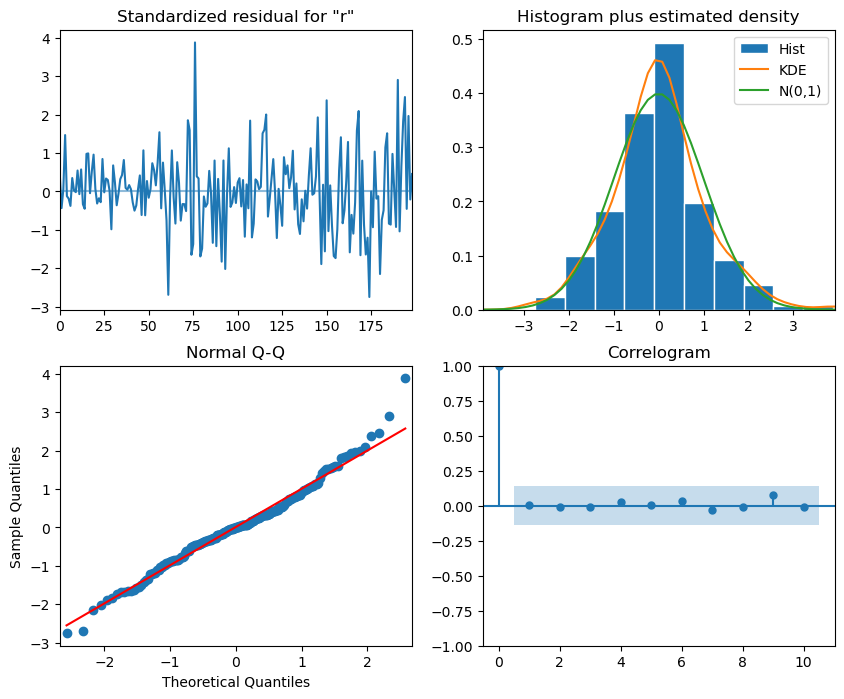

In [ ]:
best_model_fit.plot_diagnostics(figsize=(10,8));

The top left plot shows that the residuals have no trend and a
constant variance over time, just like white noise. The top right plot shows that their
distribution is very similar to a normal distribution. This is further supported by the Q-Q plot
on the bottom left that displays a fairly straight line that lies on y = x. Finally, the
correlogram on the bottom right shows no significant coefficients after lag 0. Therefore,
everything points in the direction that the residuals are completely random, just like white
noise. Our model passes the visual check.

Now, we apply the Ljung-Box test to determine if the residuals are not correlated. We
therefore want to see p-values that are greater than 0.05, since the null hypothesis of the
Ljung-Box test is that residuals are independent and uncorrelated.

In [ ]:
residuals = best_model_fit.resid
residuals

lb_stat


All p-values printed are greater than 0.05. Therefore, we do not reject the null hypothesis
and conclude that the residuals are independent and uncorrelated. Having passed both
residuals checks, our model can be used for forecasting.

Instead, to test our model, we predict the next timestep multiple times and average the error of each prediction. This is done using the recursive_forecast function. As a baseline model, we will use the last value method.

In [ ]:
def recursive_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list],train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon
    if method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value
    elif method == 'SARIMAX':
        pred_SARIMAX = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(3,1,3),seasonal_order=(0,0,0,4), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
        return pred_SARIMAX

The recursive_forecast function allows us to predict the next timestep over a certain
period of time. Specifically, we will use it to forecast the next timestep starting in 2008 to the
third quarter of 2009.

In [ ]:
target_train = target[:196]
target_test = target[196:]
pred_df = pd.DataFrame({'actual': target_test})
TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1
pred_last_value = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW,'last')
pred_SARIMAX = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW,'SARIMAX')
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX
pred_df

,actual,pred_last_value,pred_SARIMAX
196,13366.865,13391.249,13344.063417
197,13415.266,13366.865,13373.512197
198,13324.600,13415.266,13378.795329
199,13141.920,13324.600,13327.774616
200,12925.410,13141.920,13133.659610
201,12901.504,12925.410,12886.614325
202,12990.341,12901.504,12873.794701


With the predictions done, we can visualize which model has the lowest mean absolute
percentage error or MAPE.

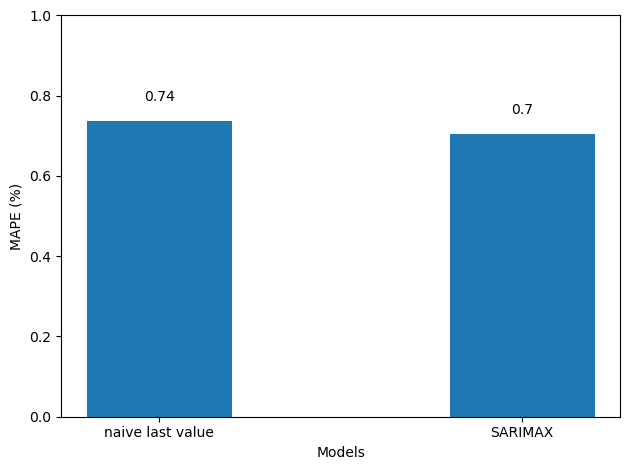

In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)
fig, ax = plt.subplots()

x = ['naive last value', 'SARIMAX']
y = [mape_last, mape_SARIMAX]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')
plt.tight_layout()

We see that the SARIMAX model is the winning model by only
0.04%. We can appreciate the importance of a baseline here, as both methods achieve an
extremely low MAPE, showing that the SARIMAX model is only slightly better than simply
predicting the last value. This is where the business context comes into play. In our case,
since we are predicting the real GDP of the United States, a difference of 0.04% represents
thousands of dollars. This difference might be relevant in this particular context, justifying
the use of the SARIMAX model, even though it is only slightly better than the baseline.

The addition of exogenous variables comes with a caveat where if we need to predict
many timesteps into the future, we must then also predict the exogenous variables, which
can magnify the prediction error on the target. To avoid that, we must then only predict the
next timestep.